In [1]:
import pandas as pd
from pymongo import MongoClient

import matplotlib.pyplot as plt
import seaborn as sns
import pylab as py 

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox

Connect to MongoDB

In [2]:
client = MongoClient('localhost', 27017)
db = client['GithubRepo']
print(db.list_collection_names())
CodeQuality_Record = db['CodeQuality_Record']

['JavaScript_top500', 'Commit_Record', 'reposInfo', 'Documentation_Record', 'CodeQuality_Record', 'Timezone_Record', 'JavaScript_60']


In [3]:
df = pd.DataFrame(list(CodeQuality_Record.find()))

# drop the _id column
df = df.drop(['_id'], axis=1)

print(df.columns)

Index(['url', 'name', 'owner', 'popularity', 'popular_level', 'code_smell',
       'ncloc', 'complexity', 'cognitive_complexity', 'bugCount', 'repo_age',
       'repo_size', 'team_size', 'bug_pronesses', 'code_smell_per_loc',
       'cognitive_complexity_per_loc'],
      dtype='object')


In [4]:
df.shape

(120, 16)

In [5]:
df.head(5)

,url,name,owner,popularity,popular_level,code_smell,ncloc,complexity,cognitive_complexity,bugCount,repo_age,repo_size,team_size,bug_pronesses,code_smell_per_loc,cognitive_complexity_per_loc
0,https://github.com/emberjs/ember.js,ember.js,emberjs,105458627,high,1087,113719,18010,5003,3774,4635,96853,30,0.168347,0.009559,0.043994
1,https://github.com/CesiumGS/cesium,cesium,CesiumGS,36823334,high,17938,796360,104432,99577,5366,4353,804770,18,0.134358,0.022525,0.125040
2,https://github.com/bgoonz/BGOONZ_BLOG_2.0,BGOONZ_BLOG_2.0,bgoonz,9132557,high,4735,49865,9678,34624,80,995,2618011,3,0.005613,0.094956,0.694355
3,https://github.com/travis-ci/travis-web,travis-web,travis-ci,6569915,high,372,57719,6618,3262,1270,4246,148464,15,0.210265,0.006445,0.056515
4,https://github.com/nwjs/nw.js,nw.js,nwjs,746241,high,881,21117,2367,2145,1191,4411,287101,6,0.233438,0.041720,0.101577


Descriptive Analysis

In [6]:
# seperate df into popular_df and unpopular_df
# use popular_level to seperate
js_popular_df = df[df['popular_level'] == 'high']
js_unpopular_df = df[df['popular_level'] == 'low']

print(js_popular_df.shape)
print(js_unpopular_df.shape)

(60, 16)
(60, 16)


In [7]:
js_popular_df['bug_pronesses'].describe()

count    60.000000
mean      0.125790
std       0.109108
min       0.003610
25%       0.064176
50%       0.115766
75%       0.160485
max       0.756659
Name: bug_pronesses, dtype: float64

In [8]:
js_unpopular_df['bug_pronesses'].describe()

count    60.000000
mean      0.109887
std       0.136930
min       0.000000
25%       0.030080
50%       0.070846
75%       0.124856
max       0.641071
Name: bug_pronesses, dtype: float64

In [9]:
js_popular_df['code_smell_per_loc'].describe()

count    60.000000
mean      0.041521
std       0.038052
min       0.000000
25%       0.011001
50%       0.031177
75%       0.061064
max       0.198570
Name: code_smell_per_loc, dtype: float64

In [10]:
js_unpopular_df['code_smell_per_loc'].describe()

count    60.000000
mean      0.036363
std       0.040643
min       0.000000
25%       0.008766
50%       0.023626
75%       0.044362
max       0.177033
Name: code_smell_per_loc, dtype: float64

In [11]:
js_popular_df['cognitive_complexity_per_loc'].describe()

count    60.000000
mean      0.108578
std       0.161858
min       0.000000
25%       0.037545
50%       0.057721
75%       0.099913
max       0.944654
Name: cognitive_complexity_per_loc, dtype: float64

In [12]:
js_unpopular_df['cognitive_complexity_per_loc'].describe()

count    60.000000
mean      0.062554
std       0.083318
min       0.000000
25%       0.017409
50%       0.032230
75%       0.055835
max       0.402597
Name: cognitive_complexity_per_loc, dtype: float64

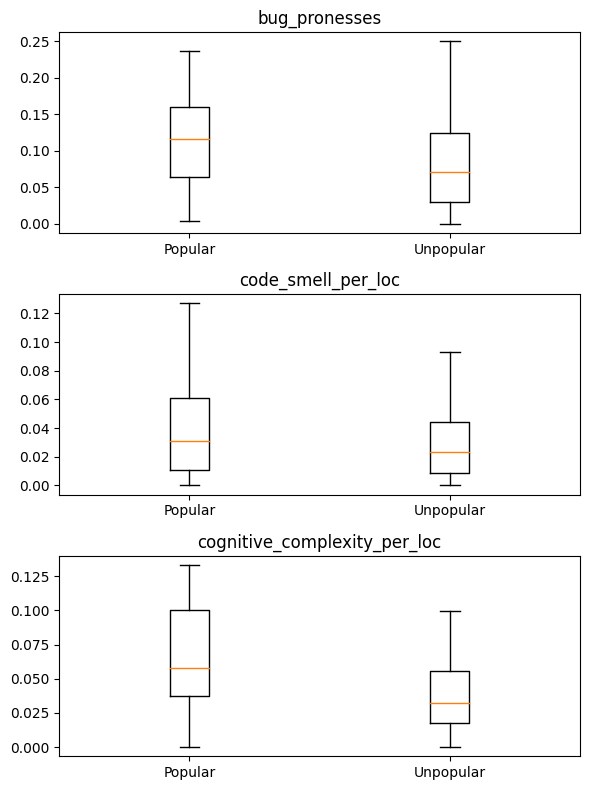

In [13]:
# Create a figure with six subplots, arranged in 4 rows and 1 columns
fig, axes = plt.subplots(3, 1, figsize=(6, 8))

# Define column names and titles
columns = ['bug_pronesses', 'code_smell_per_loc', 'cognitive_complexity_per_loc']
titles = ['bug_pronesses', 'code_smell_per_loc', 'cognitive_complexity_per_loc']

# Loop through each metric to plot
for i, (column, title) in enumerate(zip(columns, titles)):
    # Combine data from popular and unpopular dataframes for plotting
    data_to_plot = [js_popular_df[column], js_unpopular_df[column]]
    
    # Plot boxplot for popular and unpopular dataframes without outliers
    axes[i].boxplot(data_to_plot, showfliers=False)
    axes[i].set_title(title)
    axes[i].set_xticklabels(['Popular', 'Unpopular'])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [14]:
df['bug_pronesses'].describe()

count    120.000000
mean       0.117839
std        0.123540
min        0.000000
25%        0.048663
50%        0.090213
75%        0.149680
max        0.756659
Name: bug_pronesses, dtype: float64

Collinearity

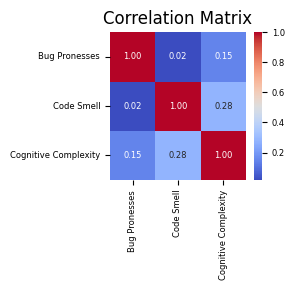

In [15]:
df_corr = df[['bug_pronesses', 'code_smell_per_loc', 'cognitive_complexity_per_loc']].corr(method='spearman')

# Create a figure without subplots
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Use seaborn's heatmap function to plot the correlation matrix
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', square=False, ax=ax, annot_kws={"size": 6})

# Set the title of the heatmap
custom_labels = ['Bug Pronesses', 'Code Smell', 'Cognitive Complexity']
ax.set_title('Correlation Matrix')
ax.set_xticklabels(custom_labels, rotation=90, fontsize=6)
ax.set_yticklabels(custom_labels, rotation=0, fontsize=6)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [16]:
X = df[['bug_pronesses', 'code_smell_per_loc', 'cognitive_complexity_per_loc']]

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,bug_pronesses,1.408414
1,code_smell_per_loc,1.972986
2,cognitive_complexity_per_loc,1.697135


Multivariate Linear Model

In [17]:
df['repo_age'], _ = boxcox(df['repo_age'])
df['repo_size'], _ = boxcox(df['repo_size'])
df['team_size'], _ = boxcox(df['team_size'])

GLM - Negative Binomial

In [18]:
# Define the independent variables and add a constant term (for the intercept)
X = df[['bug_pronesses', 'code_smell_per_loc', 'cognitive_complexity_per_loc']]
X = sm.add_constant(X)

# Define the dependent variable
y = df['popularity']

# Fit the Negative Binomial Regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             popularity   No. Observations:                  120
Model:                            GLM   Df Residuals:                      116
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1696.6
Date:                Fri, 15 Mar 2024   Deviance:                       1213.2
Time:                        13:35:47   Pearson chi2:                 3.24e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.8837
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Let Developer Size, Project Age, and Repo Size as confounding variable

In [19]:
X = df[['bug_pronesses', 'code_smell_per_loc', 'cognitive_complexity_per_loc', 'repo_age', 'repo_size', 'team_size']]
X = sm.add_constant(X)

y = df['popularity']

# Fit the Negative Binomial Regression model with the confounder
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             popularity   No. Observations:                  120
Model:                            GLM   Df Residuals:                      113
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1408.5
Date:                Fri, 15 Mar 2024   Deviance:                       637.03
Time:                        13:35:47   Pearson chi2:                 1.11e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.9990
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
